In [8]:
import torch
from torchvision import datasets, transforms
import timm
from torch import nn
from torch.optim import Adam
import loralib
from torch.nn import CrossEntropyLoss

import matplotlib.pyplot as plt
from PIL import Image

from layers import Linear

In [15]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit the ViT model input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = datasets.ImageFolder('../data/ISIC2018/Image', transform=transform)
val_dataset = datasets.ImageFolder('../val_data_new/ISIC2018/Image', transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)


In [4]:
class ViT_LoRA(nn.Module):
    def __init__(self, num_classes=7):
        super(ViT_LoRA, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        
        self.fc = nn.Sequential(
            loralib.Linear(1024,512,r=16),
            nn.ReLU(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128,num_classes)
        )
    def forward(self, x):
        return self.vit(x)

model = ViT_LoRA()

ViT_LoRA(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
     

In [9]:
def apply_lora(model, lora_params):
    """
    Apply LoRA to the specified layers of the model.

    Parameters:
    model (nn.Module): The PyTorch model to be modified.
    lora_params (dict): Parameters for LoRA modification, including 'r' and 'lora_alpha'.
    """

    for name, module in model.named_children():
        # Apply LoRA to linear layers as an example
        if isinstance(module, nn.Linear):
            # Extracting the parameters for the LoRA layer
            in_features = module.in_features
            out_features = module.out_features
            lora_layer = Linear(in_features, out_features, r=lora_params['r'], 
                                lora_alpha=lora_params['lora_alpha'])

            # Replace the original layer with the LoRA layer
            setattr(model, name, lora_layer)
        
        elif len(list(module.children())) > 0:
            # Recursively apply LoRA to child modules
            apply_lora(module, lora_params)

In [21]:
lora_params = {'r':4, 'lora_alpha':2}
apply_lora(model, lora_params)
model.to(device)

ViT_LoRA(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
     

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ViT_LoRA(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
     

In [11]:
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [22]:
def train(model, train_loader, criterion, optimizer, device):
    print(device)
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    return train_loss, train_acc

def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    return val_loss, val_acc

In [23]:
num_epochs = 100
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

cuda
Epoch 1/100, Train Loss: 1.1511, Train Acc: 0.6606, Val Loss: 1.1990, Val Acc: 0.6065
cuda
Epoch 2/100, Train Loss: 0.9324, Train Acc: 0.6752, Val Loss: 1.1307, Val Acc: 0.6118
cuda
Epoch 3/100, Train Loss: 0.8865, Train Acc: 0.6868, Val Loss: 1.1087, Val Acc: 0.6111
cuda
Epoch 4/100, Train Loss: 0.8636, Train Acc: 0.6918, Val Loss: 1.0965, Val Acc: 0.6224
cuda
Epoch 5/100, Train Loss: 0.8317, Train Acc: 0.6995, Val Loss: 1.0565, Val Acc: 0.6296
cuda
Epoch 6/100, Train Loss: 0.8244, Train Acc: 0.7028, Val Loss: 1.0476, Val Acc: 0.6389
cuda
Epoch 7/100, Train Loss: 0.7970, Train Acc: 0.7115, Val Loss: 1.0104, Val Acc: 0.6409
cuda
Epoch 8/100, Train Loss: 0.7849, Train Acc: 0.7150, Val Loss: 0.9946, Val Acc: 0.6561
cuda
Epoch 9/100, Train Loss: 0.7764, Train Acc: 0.7168, Val Loss: 1.0007, Val Acc: 0.6481
cuda
Epoch 10/100, Train Loss: 0.7667, Train Acc: 0.7192, Val Loss: 1.0473, Val Acc: 0.6217
cuda
Epoch 11/100, Train Loss: 0.7507, Train Acc: 0.7275, Val Loss: 1.0006, Val Acc: 0.62

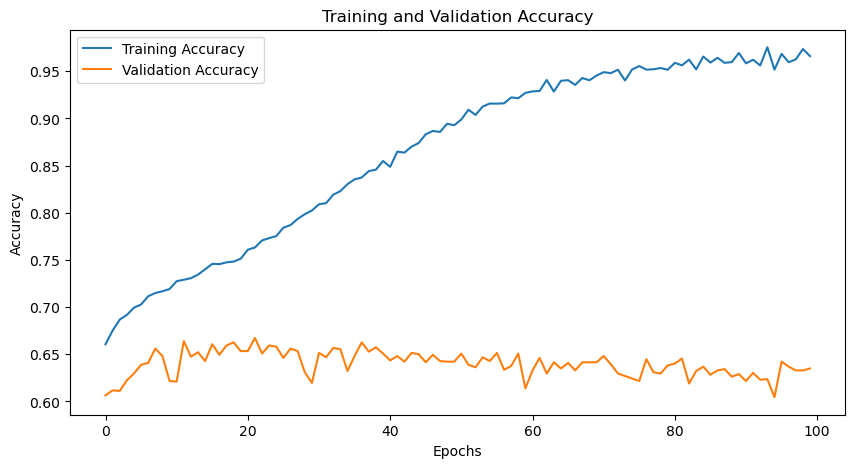

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [2]:
# Load pre-trained ViT model
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Modify the classifier head for 3 classes
model.head = nn.Linear(model.head.in_features, 3)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/home/user/miniconda3/envs/skin_cancer/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [3]:
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loralib.mark_only_lora_as_trainable(model)

In [4]:
def train_one_epoch(epoch_index):
    model.train()
    # Training code here

def validate(epoch_index):
    model.eval()
    # Validation code here

epochs = 10
for epoch in range(epochs):
    train_one_epoch(epoch)
    validate(epoch)


In [5]:
torch.save(model.state_dict(), 'vit_model.pth')

In [6]:
model.load_state_dict(torch.load('vit_model.pth'))
model.to(device)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

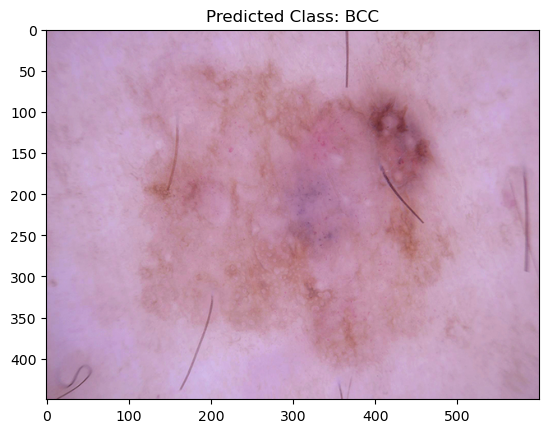

In [23]:

model.eval()
test_img = Image.open('../data/ISIC2018/Image/BKL/ISIC_0024312.jpg')
test_img_new = transform(test_img).unsqueeze(0).to(device)

# class_names = train_dataset.classes
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
with torch.no_grad():
    output = model(test_img_new)
    prediction = torch.argmax(output, dim=1).cpu()
    predicted_class = idx_to_class[prediction.item()]
    
plt.imshow(test_img)
plt.title(f'Predicted Class: {predicted_class}')
plt.show()
